# Example of using autoencoders to predict typical and anomaly data

In [1]:
import numpy as np
import keras as K
import matplotlib.pyplot as plt
from datetime import datetime
import os
from astropy.io import fits 
np.random.seed(1)
import glob

Using TensorFlow backend.


In [2]:
files_host = np.sort(glob.glob('/scratch/sbenzvi_lab/desi/time-domain/bgs/hosts/*/*coadd.fits'))
flux_host = []
for f in files_host:
    h = fits.open(f)
    fl = h[1].data
    flux_host.append(fl)
fluxes_hosts = np.concatenate(flux_host)
nonzero_hosts = fluxes_hosts.sum(axis=1)!=0
fluxes_hosts = fluxes_hosts[nonzero_hosts]
subspec_hosts = np.median(fluxes_hosts[:,:6000].reshape(-1,400,15),2)
maxflux = fluxes_hosts.max(axis=-1).reshape(-1,1)
minflux = fluxes_hosts.min(axis=-1).reshape(-1,1)
standarized_hosts = (subspec_hosts - minflux)/(maxflux-minflux)

del minflux, maxflux, flux_host, subspec_hosts, fluxes_hosts

In [3]:
files = np.sort(glob.glob('/scratch/sbenzvi_lab/desi/time-domain/bgs/sne_ia/*/*coadd.fits'))
flux = []
for f in files:
    h = fits.open(f)
    f = h[1].data
    zeros = np.zeros(400)
    flux.append(f)
fluxes = np.concatenate(flux)
nonzero = fluxes.sum(axis=1)!=0
fluxes = fluxes[nonzero]
subspec = np.median(fluxes[:,:6000].reshape(-1,400,15),2)
maxflux = fluxes.max(axis=-1).reshape(-1,1)
minflux = fluxes.min(axis=-1).reshape(-1,1)
standarized = (subspec - minflux)/(maxflux-minflux)
del minflux, maxflux, flux, subspec, fluxes

In [4]:
files_iip = np.sort(glob.glob('/scratch/sbenzvi_lab/desi/time-domain/bgs/sne_iip/*/*coadd.fits'))
flux_iip = []
for f in files_iip:
    h = fits.open(f)
    f = h[1].data
    flux_iip.append(f)
fluxes_iip = np.concatenate(flux_iip)
nonzero_iip = fluxes_iip.sum(axis=1)!=0
fluxes_iip = fluxes_iip[nonzero_iip]
subspec_iip = np.median(fluxes_iip[:,:6000].reshape(-1,400,15),2)
maxflux = fluxes_iip.max(axis=-1).reshape(-1,1)
minflux = fluxes_iip.min(axis=-1).reshape(-1,1)
standarized_iip = (subspec_iip - minflux)/(maxflux-minflux)
del minflux, maxflux, flux_iip, subspec_iip, fluxes_iip

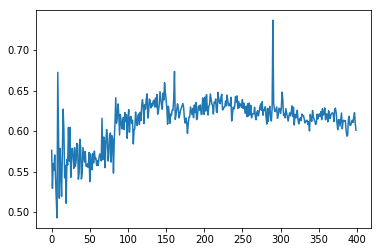

In [93]:
#Training the model on approx. 180k data points, including hosts, iip, and ia spectra
#Validating the model on 90k data points
#Testing on 45k
x_test = np.concatenate((standarized_hosts[:15000], standarized_iip[:15000], standarized[:15000]))
x_validate = np.concatenate((standarized_hosts[15000:45000], standarized_iip[15000:45000], standarized[15000:45000]))
x_train = np.concatenate((standarized_hosts[45000:], standarized_iip[45000:], standarized[45000:]))
plt.plot(x_train[0])

In [94]:
# define autoencoder 400-250-200-250-400 CNN, tanh activation between nodes.
# Note have to batch-normalize if using relu
my_init = K.initializers.glorot_uniform(seed=1)
autoenc = K.models.Sequential()
autoenc.add(K.layers.Dense(input_dim=400, units=250, 
  activation='tanh', kernel_initializer=my_init))
autoenc.add(K.layers.Dense(units=200, 
  activation='tanh', kernel_initializer=my_init))
autoenc.add(K.layers.Dense(units=250, 
  activation='tanh', kernel_initializer=my_init)) 
autoenc.add(K.layers.Dense(units=400,
  activation='tanh', kernel_initializer=my_init))

In [95]:
# Compile with Adam Optimizer
simple_adam = K.optimizers.adam(lr=0.0001)  
autoenc.compile(loss='mean_squared_error',
  optimizer=simple_adam)

In [96]:
# create checkpoint directory
ct = datetime.now().strftime("%m-%d_%H:%M:%S")
basedir = f'/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run({ct})/'
path= basedir+'weights.Ep{epoch:02d}-ValLoss{val_loss:.2f}.hdf5'
os.makedirs(basedir)
checkpoint = K.callbacks.ModelCheckpoint(path, monitor='val_loss', verbose=1,
                                       save_best_only=True, mode='min')

In [98]:
# start training
print(basedir)
max_epochs = 100
h = autoenc.fit(x_train, x_train, batch_size=60, validation_data=(x_validate, x_validate),
  epochs=max_epochs, verbose=1, shuffle=True, callbacks=[checkpoint])

/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/
Train on 184335 samples, validate on 90000 samples
Epoch 1/100
184335/184335 [==============================] - 23s 124us/step - loss: 3.3702e-04 - val_loss: 2.5822e-04

Epoch 00001: val_loss improved from inf to 0.00026, saving model to /scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/weights.Ep01-ValLoss0.00.hdf5
Epoch 2/100
184335/184335 [==============================] - 23s 125us/step - loss: 2.6146e-04 - val_loss: 2.1660e-04

Epoch 00002: val_loss improved from 0.00026 to 0.00022, saving model to /scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/weights.Ep02-ValLoss0.00.hdf5
Epoch 3/100
184335/184335 [==============================] - 24s 128us/step - loss: 2.0815e-04 - val_loss: 1.6528e-04

Epoch 00003: val_loss improved from 0.00022 to 0.00017, saving model to /scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spe


Epoch 00030: val_loss improved from 0.00006 to 0.00006, saving model to /scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/weights.Ep30-ValLoss0.00.hdf5
Epoch 31/100
184335/184335 [==============================] - 23s 123us/step - loss: 6.4222e-05 - val_loss: 6.4190e-05

Epoch 00031: val_loss did not improve from 0.00006
Epoch 32/100
184335/184335 [==============================] - 23s 122us/step - loss: 6.3439e-05 - val_loss: 6.1103e-05

Epoch 00032: val_loss improved from 0.00006 to 0.00006, saving model to /scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/weights.Ep32-ValLoss0.00.hdf5
Epoch 33/100
184335/184335 [==============================] - 23s 123us/step - loss: 6.2713e-05 - val_loss: 6.1063e-05

Epoch 00033: val_loss improved from 0.00006 to 0.00006, saving model to /scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/weights.Ep33-ValLoss0.00.hdf5
Epoch 34/100
184335/1843


Epoch 00100: val_loss did not improve from 0.00004


# Function of Loss over Epochs

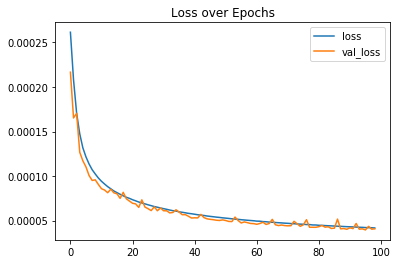

In [100]:
plt.title('Loss over Epochs')
plt.plot(h.history['loss'][1:], label='loss')
plt.plot(h.history['val_loss'][1:], label='val_loss')
plt.legend()
plt.show()

# Example of Predicting a Typical Data Vector

In [101]:
# Predict validation set again
x_predict = autoenc.predict(x=x_test, batch_size=60)

In [102]:
err = x_predict - x_test
mse_test = np.mean(np.square(err), axis=1)

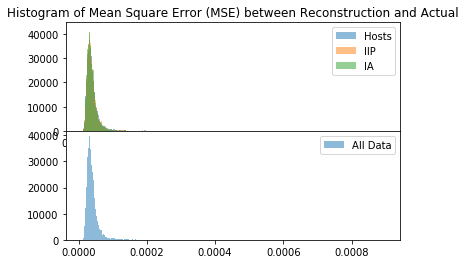

In [112]:
fig, axs = plt.subplots(2,1, sharex=True)
fig.subplots_adjust(hspace=0)
plt.subplot(2,1,1)
plt.hist(mse_test[:15000], density=1, label='Hosts', bins='auto', alpha=0.5)
plt.hist(mse_test[15000:30000], density=1, label='IIP', bins='auto', alpha=0.5)
plt.hist(mse_test[30000:45000], density=1, label='IA', bins='auto', alpha=0.5)
plt.title('Histogram of Mean Square Error (MSE) between Reconstruction and Actual')
plt.legend()
plt.subplot(2,1,2)
plt.hist(mse_test, density=1, label='All Data', bins='auto', alpha=0.5)
plt.legend()
plt.show()

# Filtering for Anomalies and best reconstructions

In [108]:
#gives the indices to in the original x_test and x_predict lists
anomalies = [i for i,j in enumerate([i>0.00015 for i in mse_test]) if j==True]
best_data = [i for i,j in enumerate([i<0.00002 for i in mse_test]) if j==True]

# One of the anomaly reconstructions in validation

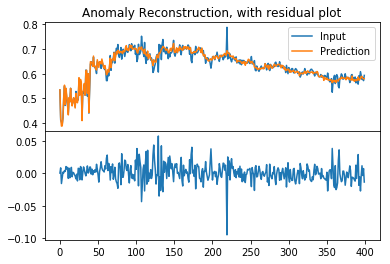

In [110]:

fig, axs = plt.subplots(2,1, sharex=True)
fig.subplots_adjust(hspace=0)
plt.subplot(2,1,1)
plt.title('Anomaly Reconstruction, with residual plot')
plt.plot(x_test[anomalies[1]], label='Input')
plt.plot(x_predict[anomalies[1]], label='Prediction')
plt.legend()
plt.subplot(2,1,2)
plt.plot(err[anomalies[1]])
plt.show()

# One of the best reconstructions in validation

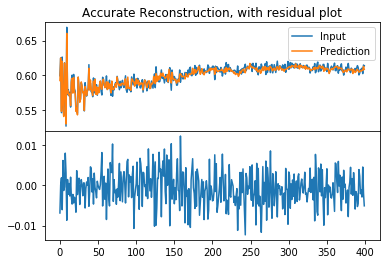

In [111]:
fig, axs = plt.subplots(2,1, sharex=True)
fig.subplots_adjust(hspace=0)
plt.subplot(2,1,1)
plt.title('Accurate Reconstruction, with residual plot')
plt.plot(x_test[best_data[7]], label='Input')
plt.plot(x_predict[best_data[7]], label='Prediction')
plt.legend()
plt.subplot(2,1,2)
plt.plot(err[best_data[7]])
plt.show()

In [ ]:
#Trained on only host data
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-01_17:35:08)/')
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-01_18:07:05)/')
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-03_15:12:22)/')
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-03_15:32:20)/') #4.0262e-05
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-03_16:21:23)/') #3.3759e-05

#Trained on 270k data with host, IA, and IIP
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_10:02:38)/weights.Ep100-ValLoss0.00.hdf5') #3.4762e-05, underfitting

#Trained on 180k data with host, IA, and IIP, test data is first 15k on each type
print('/scratch/dgandhi/desi/time-domain-bkup/models/autoencoder-spectra/run(07-08_12:41:30)/weights.Ep97-ValLoss0.00.hdf5') #4.0814e-05